### An analysis in the Glitne field with Gassmann fluid substitution

Dataset: well #2 from Avseth et al. (2010)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import avo_func2 as avo
import las
from matplotlib.gridspec import GridSpec
import pandas as pd
from scipy.io import loadmat
import pandas as pd
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
np.warnings.filterwarnings('ignore')

%matplotlib inline

Import well 2

In [2]:
well_2 = las.LASReader('well_2.las', null_subs=np.nan)
w2z=well_2.data['DEPT']
w2vp=well_2.data['Vp']*1000 #m/s
w2vs=well_2.data['Vs']*1000 #m/s
#w2rho_old=well_2.data['RHOB']
w2gr=well_2.data['GR']
#clay content (%) = (GR - GRmin)/(GRmax - GRmin)
w2vsh = (w2gr-np.min(w2gr))/(np.max(w2gr)-np.min(w2gr))

tops_well2={'Heimdal': 2153,'OWC': 2183}

#corrected RHOB log
_, w2rho = np.loadtxt('well_2_denscorr.txt', skiprows=1,
                      unpack=True)

#Sw and Sw_x 
_, w2sw, w2swx = np.loadtxt('well_2_sats.txt', skiprows=1,
                            unpack=True)

annots = loadmat('facies_wells.mat')
w2facies = annots['facies_well2'][:,1].astype(int)

In [3]:
facies_colors = ['#FFD700','#FFA500','#DAA500',
                 '#DC7633','#808000','#008000']
cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')

In [4]:
#select plot area
index_top = (np.abs(w2z - 2130)).argmin()
index_base = (np.abs(w2z - 2210)).argmin()

w2z = w2z[index_top:index_base]
w2vp = w2vp[index_top:index_base]
w2vs = w2vs[index_top:index_base]
w2rho = w2rho[index_top:index_base]
w2gr = w2gr[index_top:index_base]
w2sw = w2sw[index_top:index_base]
w2swx = w2swx[index_top:index_base]
w2vsh = w2vsh[index_top:index_base]
w2facies = w2facies[index_top:index_base]

In [5]:
d = {'Depth': w2z, 'Vp': w2vp, 'Vs': w2vs, 'Rho':w2rho,
     'Gr':w2gr, 'Sw':w2sw, 'Swx':w2swx, 'Vsh':w2vsh, 'Facies':w2facies}

df = pd.DataFrame(data=d)

In [6]:
#select reservoir area
index_top_r = (np.abs(w2z - 2153)).argmin()
index_base_r = (np.abs(w2z - 2183)).argmin()

#### Voigt-Reuss-Hill averaging

In [7]:
#parameters from Avseth et al. (2001) and Avseth et al. (2005)
rho_b=1.09; k_b=2.8 #brine density & bulk modulus
rho_o=0.78; k_o=0.94 #oil density & bulk modulus 
rho_qz=2.65; k_qz=36.8; mu_qz=44 #quartz density, bulk modulus and shear modulus
rho_sh=2.81; k_sh=15; mu_sh=5 #clay density, bulk modulus and shear modulus

In [8]:
## rho_matrix
w2rhom=w2vsh*rho_sh + (1-w2vsh)*rho_qz
# rho_fluid 
w2rhof = w2sw*rho_b + (1-w2sw)*rho_o
#porosity
w2phi = (w2rhom-w2rho)/(w2rhom- w2rhof)

w2sand = 1 - w2vsh - w2phi
# normalized the volumes of shale and sand 
w2vsh_N = w2vsh/(w2vsh+w2sand)  
w2sand_N = w2sand/(w2vsh+w2sand)

# mineral mixture bulk and shear moduli, k0 and mu0
k_u, k_l, mu_u, mu_l, k0, mu0 = avo.vrh([w2vsh_N, w2sand_N], [k_sh, k_qz], [mu_sh, mu_qz])

# fluid mixture bulk modulus, using the same vrh function but capturing the Reuss average (second output)
water = w2sw
w2hc = 1 - w2sw
_, k_fl, _, _, _, _ = avo.vrh([water, w2hc], [k_b, k_o], [0, 0])

# fluid mixture density
rho_fl = w2sw*rho_b + w2hc*rho_o

### Gassmann

In [9]:
#brine and oil
vp_out_b, vs_out_b, rho_out_b = avo.gassmann(w2vp,w2vs,w2rho,w2phi,k0,k_fl,rho_fl,k_b,rho_b)
vp_out_o, vs_out_o, rho_out_o = avo.gassmann(w2vp,w2vs,w2rho,w2phi,k0,k_fl,rho_fl,k_o,rho_o)

w2vp_brine=np.copy(w2vp);w2vs_brine=np.copy(w2vs);w2rho_brine=np.copy(w2rho)
w2vp_oil=np.copy(w2vp);w2vs_oil=np.copy(w2vs);w2rho_oil=np.copy(w2rho)

w2vp_brine[index_top_r:index_base_r]=vp_out_b[index_top_r:index_base_r]
w2vs_brine[index_top_r:index_base_r]=vs_out_b[index_top_r:index_base_r]
w2rho_brine[index_top_r:index_base_r]=rho_out_b[index_top_r:index_base_r]

w2vp_oil[index_top_r:index_base_r]=vp_out_o[index_top_r:index_base_r]
w2vs_oil[index_top_r:index_base_r]=vs_out_o[index_top_r:index_base_r]
w2rho_oil[index_top_r:index_base_r]=rho_out_o[index_top_r:index_base_r]

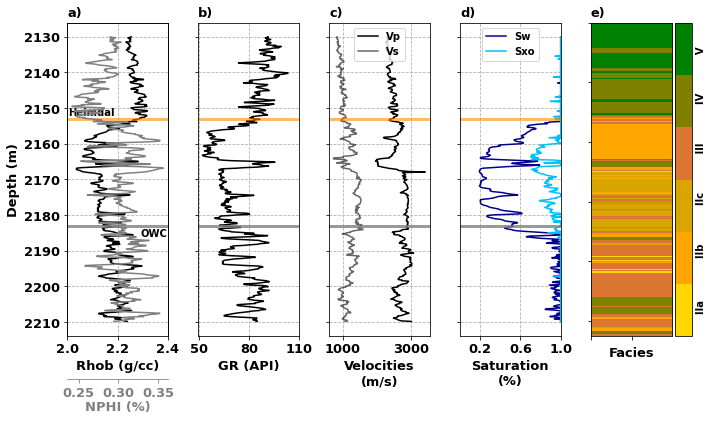

In [24]:
fig=plt.figure(figsize=(10,6))

ax=plt.subplot(1,5,1)
ax.set_title('a)',loc='left',fontsize=13)
ax.plot(w2rho,w2z,'black')
ax.set_xlabel('Rhob (g/cc)', fontsize=13)
ax.set_ylabel('Depth (m)', fontsize=13)
ax.grid(linestyle='--')
ax.axhline(y=float(tops_well2['Heimdal']),color='darkorange',lw=3,alpha=0.6)
ax.axhline(y=float(tops_well2['OWC']),color='gray',lw=3,alpha=0.8)
ax.invert_yaxis()
ax.text(2.005,tops_well2['Heimdal']-1,'Heimdal')
ax.text(2.29,tops_well2['OWC']+3,'OWC')
ax.tick_params(labelsize=13)
ax.set_xlim(2.0,2.4)

ax2 = ax.twiny()
ax2.plot(w2phi,w2z,'grey')
ax2.set_xlabel('NPHI (%)', fontsize=13)
ax2.tick_params(axis='x', colors="grey",labelsize=13)
ax2.xaxis.set_ticks_position("bottom")
ax2.spines["bottom"].set_position(("axes", -0.14))
ax2.xaxis.label.set_color("grey")
ax2.spines["bottom"].set_edgecolor("grey")
ax2.xaxis.set_label_coords(0.5, -0.24)
#ax2.set_xticks([50,80,110])


ax=plt.subplot(1,5,2)
ax.set_title('b)',loc='left',fontsize=13)
ax.plot(w2gr,w2z,'black')
ax.set_xlabel('GR (API)', fontsize=13)
ax.tick_params(axis='x', colors="black",labelsize=13)
ax.xaxis.set_ticks_position("bottom")
ax.axhline(y=float(tops_well2['Heimdal']),color='darkorange',lw=3,alpha=0.6)
ax.axhline(y=float(tops_well2['OWC']),color='gray',lw=3,alpha=0.8)
ax.grid(linestyle='--')
ax.xaxis.label.set_color("black")
ax.set_xticks([50,80,110])
ax.set_yticklabels([])
ax.invert_yaxis()


ax=plt.subplot(1,5,3)
ax.set_title('c)',loc='left',fontsize=13)
ax.plot(w2vp,w2z,'black',label='Vp')
ax.plot(w2vs,w2z,'black',alpha=0.6,label='Vs')
ax.legend(loc='upper center')
ax.set_xlabel('Velocities\n(m/s)', fontsize=13)
ax.grid(linestyle='--')
ax.axhline(y=float(tops_well2['Heimdal']),color='darkorange',lw=3,alpha=0.6)
ax.axhline(y=float(tops_well2['OWC']),color='gray',lw=3,alpha=0.8)
ax.invert_yaxis()
ax.tick_params(labelsize=13)
ax.set_xticks([1000,3000])
ax.set_yticklabels([])

ax=plt.subplot(1,5,4)
ax.set_title('d)',loc='left',fontsize=13)
ax.plot(w2sw,w2z,c='darkblue',label='Sw')
ax.plot(w2swx,w2z,c='deepskyblue',label='Sxo')
ax.set_xlabel('Saturation\n(%)',fontsize=13)
ax.grid(linestyle='--')
ax.axhline(y=float(tops_well2['Heimdal']),color='darkorange',lw=3,alpha=0.6)
ax.axhline(y=float(tops_well2['OWC']),color='gray',lw=3,alpha=0.8)
ax.legend(ncol=1)
ax.invert_yaxis()
ax.set_xlim(0,1)
ax.set_xticks([0.2,0.6,1])
ax.tick_params(labelsize=13)
ax.set_yticklabels([])
ax.legend(loc='upper center')

ax=plt.subplot(1,5,5)
ax.set_title('e)',loc='left',fontsize=13)
logs = df.sort_values(by='Depth')
cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
im=ax.imshow(cluster, interpolation='none', aspect='auto',
                cmap=cmap_facies,vmin=1,vmax=6)
ax.set_xlabel('Facies',fontsize=13)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="20%", pad=0.04)
cbar=plt.colorbar(im, cax=cax)
cbar.set_label((11*' ').join(['IIa ', 'IIb', 'IIc', 
                              'III', 'IV', 'V']))
cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')    
ax.tick_params(labelsize=13)
ax.set_xticklabels([])
ax.set_yticklabels([])

plt.tight_layout()

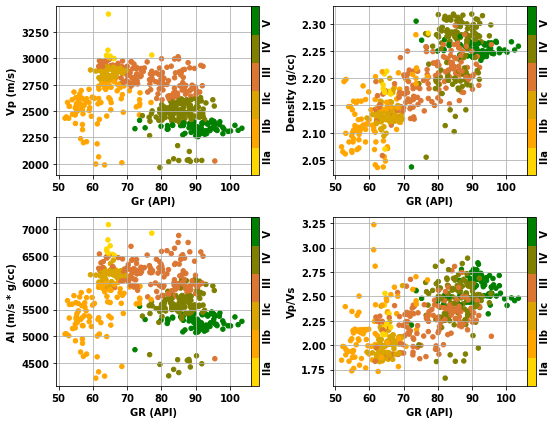

In [25]:
fig=plt.figure(figsize=(8,6))

ax=plt.subplot(2,2,1)
plt.scatter(df.Gr.values,df.Vp.values,20,c=df.Facies.values,cmap=cmap_facies)
ax.set_xlabel('Gr (API)')
ax.set_ylabel('Vp (m/s)')
plt.grid()
cbar=plt.colorbar(pad=0)
cbar.set_label((4*' ').join(['IIa ', 'IIb', 'IIc', 
                              'III', 'IV', 'V']))
cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')

ax=plt.subplot(2,2,2)
plt.scatter(df.Gr.values,df.Rho.values,20,c=df.Facies.values,cmap=cmap_facies)
ax.set_xlabel('GR (API)')
ax.set_ylabel('Density (g/cc)')
plt.grid()
cbar=plt.colorbar(pad=0)
cbar.set_label((4*' ').join(['IIa ', 'IIb', 'IIc', 
                              'III', 'IV', 'V']))
cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')

ax=plt.subplot(2,2,3)
plt.scatter(df.Gr.values,df.Vp.values*df.Rho.values,20,c=df.Facies.values,cmap=cmap_facies)
ax.set_xlabel('GR (API)')
ax.set_ylabel('AI (m/s * g/cc)')
plt.grid()
cbar=plt.colorbar(pad=0)
cbar.set_label((4*' ').join(['IIa ', 'IIb', 'IIc', 
                              'III', 'IV', 'V']))
cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')

ax=plt.subplot(2,2,4)
plt.scatter(df.Gr.values,df.Vp.values/df.Vs.values,20,c=df.Facies.values,cmap=cmap_facies)
ax.set_xlabel('GR (API)')
ax.set_ylabel('Vp/Vs')
plt.grid()
cbar=plt.colorbar(pad=0)
cbar.set_label((4*' ').join(['IIa ', 'IIb', 'IIc', 
                              'III', 'IV', 'V']))
cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')

plt.tight_layout()

### Poisson ratio, acoustic impedance and elastic impedance

In [26]:
vpvs_oil=w2vp_oil/w2vs_oil
vpvs_brine=w2vp_brine/w2vs_brine
vpvs_input=w2vp/w2vs
#poisson ratio
pr_oil=avo.pr(w2vp_oil,w2vs_oil)
pr_brine=avo.pr(w2vp_brine,w2vs_brine)
pr_input=avo.pr(w2vp,w2vs)
#acoustic impedance
ai_oil=avo.ai(w2vp_oil,w2rho_oil)
ai_brine=avo.ai(w2vp_brine,w2rho_brine)
ai_input=avo.ai(w2vp,w2rho)
#elastic impedance
angle=30
ei_oil=avo.ei(w2vp_oil,w2vs_oil,w2rho_oil,angle)
ei_brine=avo.ei(w2vp_brine,w2vs_brine,w2rho_brine,angle)
ei_input=avo.ei(w2vp,w2vs,w2rho,angle)

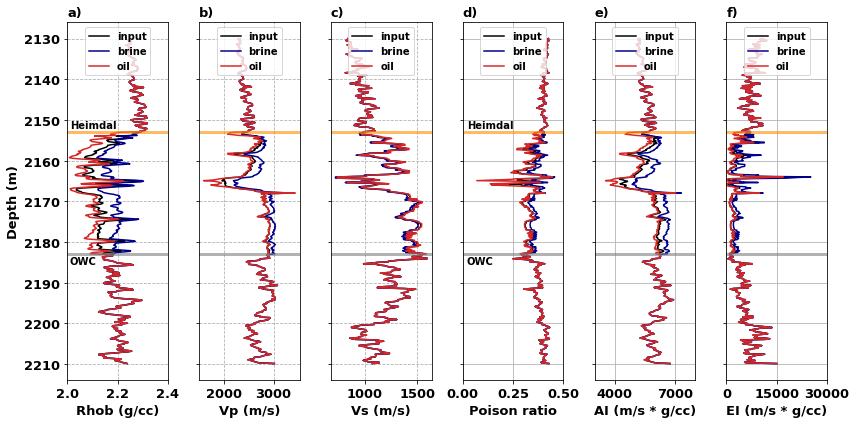

In [30]:
fig=plt.figure(figsize=(12,6))

ax=plt.subplot(1,6,1)
ax.set_title('a)',loc='left',fontsize=13)
ax.plot(w2rho,w2z,'black',label='input')
ax.plot(w2rho_brine,w2z,'darkblue',label='brine')
ax.plot(w2rho_oil,w2z,'tab:red',label='oil')
ax.legend(ncol=1,loc='upper center')
ax.set_xlabel('Rhob (g/cc)', fontsize=13)
ax.set_ylabel('Depth (m)', fontsize=13)
ax.grid(linestyle='--')
ax.axhline(y=float(tops_well2['Heimdal']),color='darkorange',lw=3,alpha=0.6)
ax.axhline(y=float(tops_well2['OWC']),color='gray',lw=3,alpha=0.6)
ax.invert_yaxis()
ax.text(2.01,tops_well2['Heimdal']-1,'Heimdal')
ax.text(2.01,tops_well2['OWC']+2.5,'OWC')
ax.tick_params(labelsize=13)
ax.set_xlim(2.0,2.4)

ax=plt.subplot(1,6,2)
ax.set_title('b)',loc='left',fontsize=13)
ax.plot(w2vp,w2z,'black',label='input')
ax.plot(w2vp_brine,w2z,'darkblue',label='brine')
ax.plot(w2vp_oil,w2z,'tab:red',label='oil')
ax.legend(ncol=1,loc='upper center')
ax.set_xlabel('Vp (m/s)', fontsize=13)
ax.grid(linestyle='--')
ax.axhline(y=float(tops_well2['Heimdal']),color='darkorange',lw=3,alpha=0.6)
ax.axhline(y=float(tops_well2['OWC']),color='gray',lw=3,alpha=0.6)
ax.invert_yaxis()
ax.tick_params(labelsize=13)
ax.set_yticklabels([])

ax=plt.subplot(1,6,3)
ax.set_title('c)',loc='left',fontsize=13)
ax.plot(w2vs,w2z,'black',label='input')
ax.plot(w2vs_brine,w2z,'darkblue',label='brine')
ax.plot(w2vs_oil,w2z,'tab:red',label='oil')
ax.legend(ncol=1,loc='upper center')
ax.set_xlabel('Vs (m/s)', fontsize=13)
ax.grid(linestyle='--')
ax.axhline(y=float(tops_well2['Heimdal']),color='darkorange',lw=3,alpha=0.6)
ax.axhline(y=float(tops_well2['OWC']),color='gray',lw=3,alpha=0.6)
ax.invert_yaxis()
ax.tick_params(labelsize=13)
ax.set_yticklabels([])

ax=plt.subplot(1,6,4)
ax.set_title('d)',loc='left',fontsize=13)
ax.set_xlabel('Poison ratio',fontsize=13)
plt.plot(pr_input,w2z,color='black',label='input')
plt.plot(pr_brine,w2z,color='darkblue',label='brine')
plt.plot(pr_oil,w2z,color='tab:red',label='oil')
ax.grid()
ax.legend(loc='upper center')
ax.tick_params(labelsize=13)
ax.axhline(y=float(tops_well2['Heimdal']),color='darkorange',lw=3,alpha=0.6)
ax.axhline(y=float(tops_well2['OWC']),color='gray',lw=3,alpha=0.6)
ax.text(0.02,tops_well2['Heimdal']-1,'Heimdal')
ax.text(0.02,tops_well2['OWC']+2.5,'OWC')
ax.invert_yaxis()
ax.set_xlim(0,0.5)
ax.set_yticklabels([])

ax=plt.subplot(1,6,5)
ax.set_title('e)',loc='left',fontsize=13)
plt.plot(ai_input,w2z,color='black',label='input')
plt.plot(ai_brine,w2z,color='darkblue',label='brine')
plt.plot(ai_oil,w2z,color='tab:red',label='oil')
ax.set_xlabel("AI (m/s * g/cc)", fontsize=13)
ax.legend(loc='upper center')
ax.grid()
ax.tick_params(labelsize=13)
ax.axhline(y=float(tops_well2['Heimdal']),color='darkorange',lw=3,alpha=0.6)
ax.axhline(y=float(tops_well2['OWC']),color='gray',lw=3,alpha=0.6)
ax.set_xlim(3000,8000)
ax.set_xticks([4000,7000])
ax.invert_yaxis()
ax.set_yticklabels([])

ax=plt.subplot(1,6,6)
ax.set_title('f)',loc='left',fontsize=13)
plt.plot(ei_input,w2z,color='black',label='input')
plt.plot(ei_brine,w2z,color='darkblue',label='brine')
plt.plot(ei_oil,w2z,color='tab:red',label='oil')
ax.set_xlabel("EI (m/s * g/cc)", fontsize=13)
ax.legend(loc='upper center')
ax.grid()
ax.tick_params(labelsize=13)
ax.axhline(y=float(tops_well2['Heimdal']),color='darkorange',lw=3,alpha=0.6)
ax.axhline(y=float(tops_well2['OWC']),color='gray',lw=3,alpha=0.6)
ax.set_xlim(0,30000)
ax.set_xticks([0,15000,30000])
ax.invert_yaxis()
ax.set_yticklabels([])

plt.tight_layout()

### AVO with Shuey 3-term

In [31]:
angle = np.arange(0,31,1)
delta = 25 #amount of values to compute the approximation
#top of input -
I_t,G_t,_,shuey_t = avo.shuey(w2vp[index_top_r-delta],w2vs[index_top_r-delta],w2rho[index_top_r-delta],w2vp[index_top_r+delta],w2vs[index_top_r+delta],w2rho[index_top_r+delta],angle)

#top of oil - after gassman
I_to,G_to,_,shuey_to = avo.shuey(w2vp_oil[index_top_r-delta],w2vs_oil[index_top_r-delta],w2rho_oil[index_top_r-delta],w2vp_oil[index_top_r+delta],w2vs_oil[index_top_r+delta],w2rho_oil[index_top_r+delta],angle)

#top of brine -
I_tb,G_tb,_,shuey_tb = avo.shuey(w2vp_brine[index_top_r-delta],w2vs_brine[index_top_r-delta],w2rho_brine[index_top_r-delta],w2vp_brine[index_top_r+delta],w2vs_brine[index_top_r+delta],w2rho_brine[index_top_r+delta],angle)

print('Intercept input: %0.3f   Gradient input: %0.3f'%(I_t,G_t))
print('Intercept oil:   %0.3f   Gradient oil:   %0.3f'%(I_to,G_to))
print('Intercept brine: %0.3f   Gradient brine: %0.3f'%(I_tb,G_tb))

Intercept input: -0.020   Gradient input: -0.143
Intercept oil:   -0.050   Gradient oil:   -0.165
Intercept brine: 0.011   Gradient brine: -0.111


### Poisson ratio and acoustic impedance

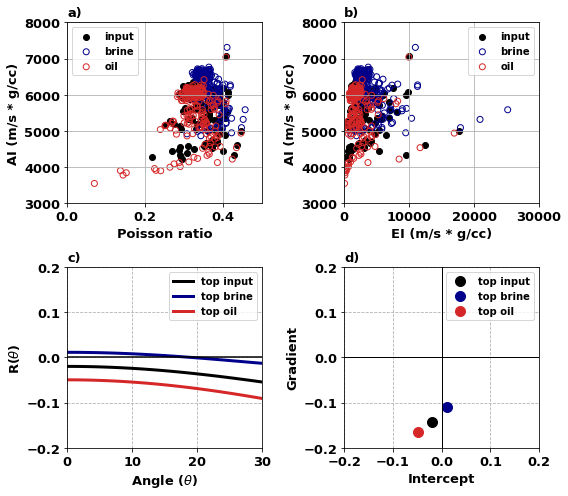

In [33]:
mxplot=0.2

fig=plt.figure(figsize=(8,7))

ax3=plt.subplot(2,2,1)
ax3.set_ylabel("Depth(m)",fontsize=13)
plt.scatter(pr_input[index_top_r:index_base_r],ai_input[index_top_r:index_base_r],c='black',label='input')
plt.scatter(pr_brine[index_top_r:index_base_r],ai_brine[index_top_r:index_base_r],edgecolors='darkblue',label='brine',facecolors='none')
plt.scatter(pr_oil[index_top_r:index_base_r],ai_oil[index_top_r:index_base_r],edgecolors='tab:red',label='oil',facecolors='none')
plt.legend()
plt.grid(True)
ax3.set_xlabel('Poisson ratio', fontsize=13)
ax3.set_ylabel('AI (m/s * g/cc)', fontsize=13)
ax3.tick_params(labelsize=13)
ax3.set_title('a)',loc='left',fontsize=13)
ax3.set_xlim(0,0.5)
ax3.set_ylim(3000,8000)

ax4=plt.subplot(2,2,2)
plt.scatter(ei_input[index_top_r:index_base_r],ai_input[index_top_r:index_base_r],c='black',label='input')
plt.scatter(ei_brine[index_top_r:index_base_r],ai_brine[index_top_r:index_base_r],edgecolors='darkblue',label='brine',facecolors='none')
plt.scatter(ei_oil[index_top_r:index_base_r],ai_oil[index_top_r:index_base_r],edgecolors='tab:red',label='oil',facecolors='none')
plt.legend()
plt.grid(True)
ax4.set_xlabel('EI (m/s * g/cc)', fontsize=13)
ax4.set_ylabel('AI (m/s * g/cc)', fontsize=13)
ax4.tick_params(labelsize=13)
ax4.set_title('b)',loc='left',fontsize=13)
ax4.set_xlim(0,30000)
ax4.set_ylim(3000,8000)

ax1=plt.subplot(2,2,3)
ax1.set_title('c)',loc='left',fontsize=13)
ax1.plot(angle,shuey_t,'-',color='black',linewidth=3,label='top input')
ax1.plot(angle,shuey_tb,'-',color='darkblue',linewidth=3,label='top brine')
ax1.plot(angle,shuey_to,'-',color='tab:red',linewidth=3,label='top oil')
ax1.axhline(0, color='k')
ax1.set_xlabel('Angle ($\\theta$)', fontsize=13)
ax1.set_ylabel('R($\\theta$)', fontsize=13)
yt=np.linspace(-mxplot,mxplot,6)
ax1.set_yticks(yt)
ax1.set_xlim(0.,np.max(angle))
ax1.set_ylim(-mxplot,mxplot)
ax1.tick_params(labelsize=13)
ax1.grid(linestyle='--')
ax1.legend(ncol=1)
ax1.set_yticks(np.linspace(-mxplot,mxplot,5))

ax2=plt.subplot(2,2,4)
ax2.set_title('d)',loc='left',fontsize=13)
ax2.plot(I_t,G_t,'o',color='black',markersize=10,label='top input')
ax2.plot(I_tb,G_tb,'o',color='darkblue',markersize=10,label='top brine')
ax2.plot(I_to,G_to,'o',color='tab:red',markersize=10,label='top oil')
ax2.axhline(0, color='k', lw=1)
ax2.axvline(0, color='k', lw=1)
ax2.set_xlabel('Intercept', fontsize=13)
ax2.set_ylabel('Gradient', fontsize=13)
ax2.set_xlim(-mxplot,mxplot)
ax2.set_ylim(-mxplot,mxplot)
yt=np.linspace(-mxplot,mxplot,6)
xt=np.linspace(-mxplot,mxplot,6)
ax2.set_yticks(yt)
ax2.set_xticks(xt)
ax2.xaxis.set_label_position('bottom')
ax2.xaxis.tick_bottom()
ax2.yaxis.set_label_position('left')
ax2.yaxis.tick_left()
ax2.tick_params(labelsize=13)
ax2.set_yticks(np.linspace(-mxplot,mxplot,5))
ax2.set_xticks(np.linspace(-mxplot,mxplot,5))
ax2.legend(ncol=1)
ax2.grid(linestyle='--')

plt.tight_layout()

## References

Amato del Monte, A. 2015b. Seismic petrophysics: Part 2. The Leading Edge, 34(6), 700-704.

Avseth, P.; Mukerji, T.; Jørstad, A.; Mavko, G.; Veggeland, T. 2001. Seismic reservoir mapping from 3-D AVO in a North Sea turbidite system. Geophysics, 66(4), 1157-1176.

Avseth, P., Mukerji, T., & Mavko, G., 2005. Quantitative seismic interpretation: Applying rock physics tools to reduce interpretation risk. Cambridge university press.

Connolly, P., 1999, Elastic impedance: The Leading Edge, 18, 438–452.

Shuey,R.T., 1985, A simplification of Zoeppritz equations: Geophysics, 50, 609–614.

Smith, T.M; Sondergeld, C.H.; Rai. C.S. 2003. Gassmann fluid substitutions: A tutorial. Geophysics, 68: 430-440.

The dataset: https://srb.stanford.edu/quantitative-seismic-interpretation

https://github.com/aadm/avo_explorer